# Use statsmodels to forecast time series data

Author
Ananya Kaushik is a Data Scientist at IBM.

Copyright © 2019 IBM. This notebook and its source code are released under the terms of the MIT License.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import datetime

In [3]:
consumer_prices = pd.read_csv('UNdata_Export_20191024_000402038.csv')
consumer_prices = consumer_prices[:7187]
consumer_prices.head()

,Country or Area,Year,Scope,Value,Value Footnotes
0,Afghanistan,1991,Kabul,143.826616,"1,2"
1,Afghanistan,1990,Kabul,100.000000,"1,2"
2,Afghanistan,1989,Kabul,67.863097,"1,2"
3,Afghanistan,1988,Kabul,39.580269,"1,2"
4,Afghanistan,1987,Kabul,31.038541,"1,2"


In [4]:
consumer_prices.shape

(7187, 5)

In [5]:
consumer_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7187 entries, 0 to 7186
Data columns (total 5 columns):
Country or Area    7187 non-null object
Year               7187 non-null object
Scope              7187 non-null object
Value              7187 non-null float64
Value Footnotes    3547 non-null object
dtypes: float64(1), object(4)
memory usage: 280.8+ KB


In [6]:
consumer_prices['Year'] = pd.to_datetime(consumer_prices['Year'], format='%Y')
consumer_prices.head()

,Country or Area,Year,Scope,Value,Value Footnotes
0,Afghanistan,1991-01-01,Kabul,143.826616,"1,2"
1,Afghanistan,1990-01-01,Kabul,100.000000,"1,2"
2,Afghanistan,1989-01-01,Kabul,67.863097,"1,2"
3,Afghanistan,1988-01-01,Kabul,39.580269,"1,2"
4,Afghanistan,1987-01-01,Kabul,31.038541,"1,2"


In [7]:
consumer_prices.set_index('Year', inplace=True)
consumer_prices.head()

,Country or Area,Scope,Value,Value Footnotes
Year,,,,
1991-01-01,Afghanistan,Kabul,143.826616,"1,2"
1990-01-01,Afghanistan,Kabul,100.000000,"1,2"
1989-01-01,Afghanistan,Kabul,67.863097,"1,2"
1988-01-01,Afghanistan,Kabul,39.580269,"1,2"
1987-01-01,Afghanistan,Kabul,31.038541,"1,2"


In [8]:
# Distribution of columns.
with pd.option_context('display.max_rows', None):
    for col in consumer_prices:
        print(col, len(consumer_prices[col].value_counts()))

Country or Area 216
Scope 98
Value 6839
Value Footnotes 257


In [9]:
import matplotlib.pyplot as plt

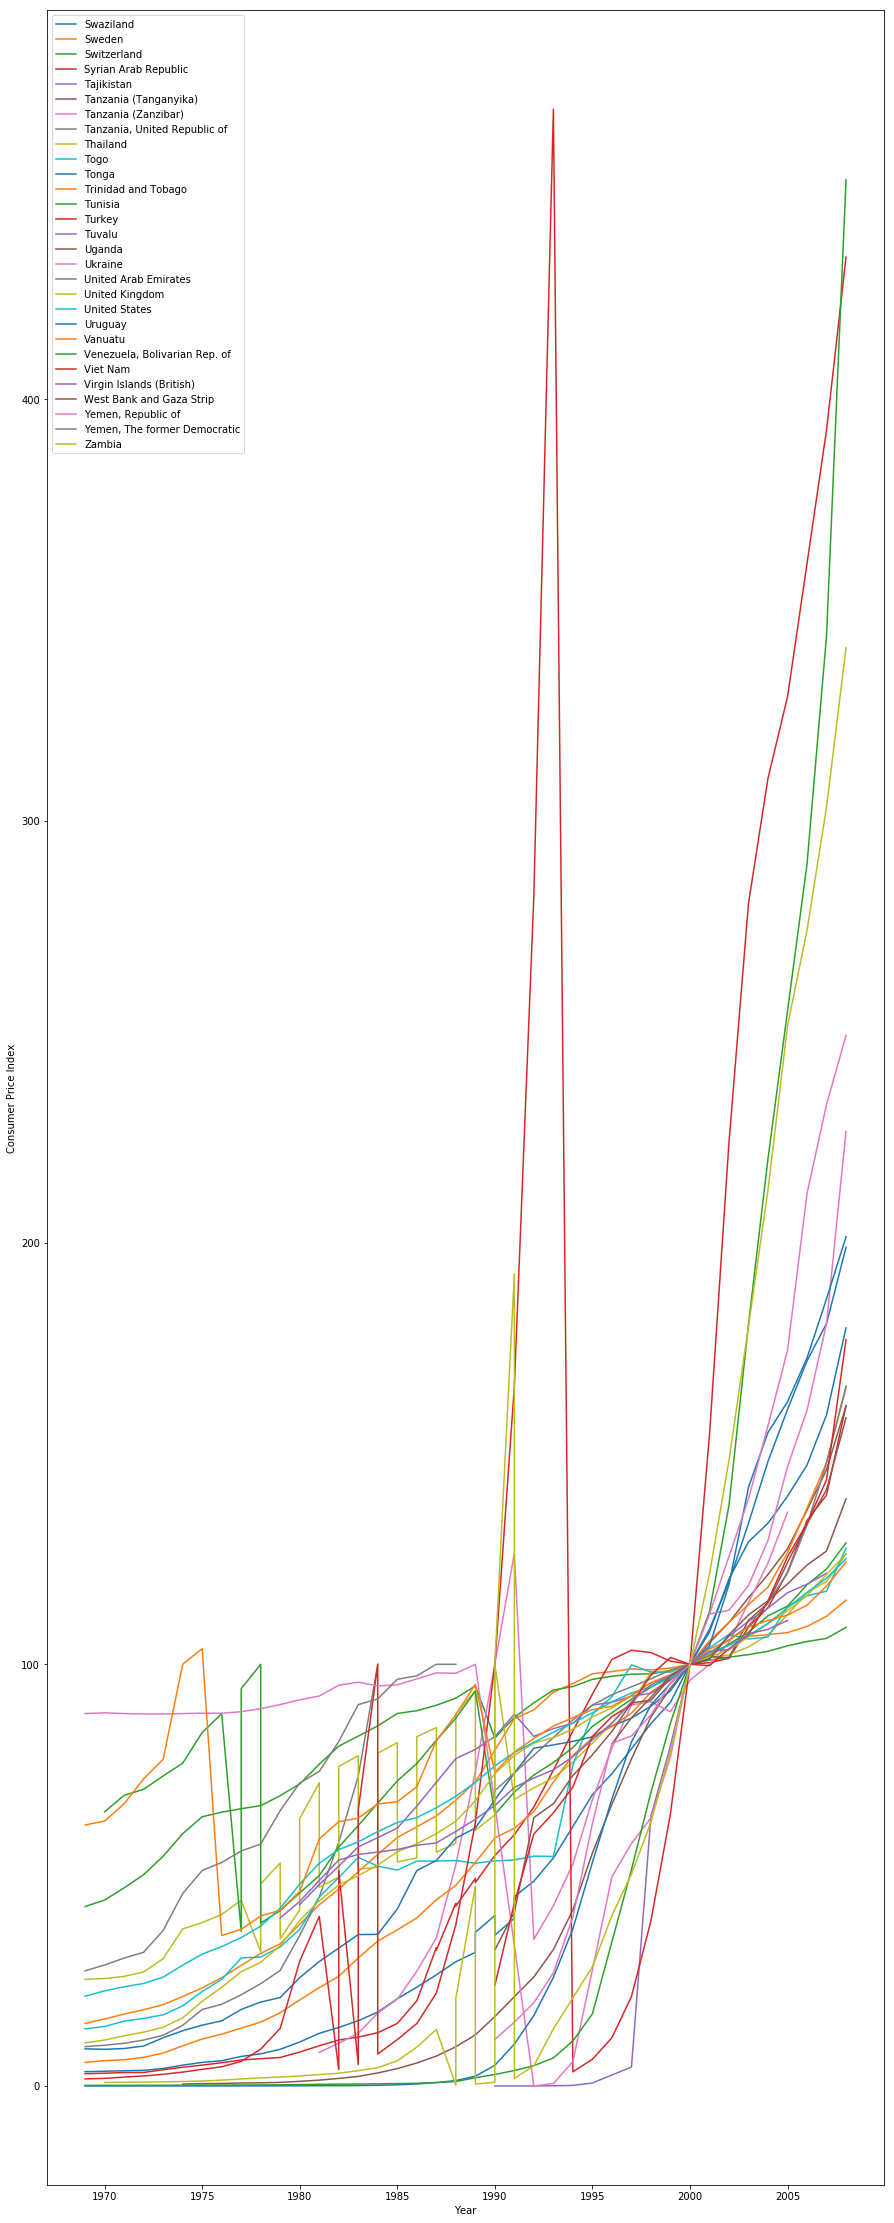

In [10]:
# Plot the data by country.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(15, 40))
for country in (consumer_prices["Country or Area"].unique()[-30:-1]):    
    plt.plot(consumer_prices.loc[(consumer_prices["Country or Area"] == country)].index.to_pydatetime(), consumer_prices["Value"].loc[consumer_prices["Country or Area"] == country], label=country)
    plt.xlabel('Year')
    plt.ylabel('Consumer Price Index')
    plt.legend()

In [11]:
# CPI values in the United States.
us_consumer_prices = consumer_prices[["Value"]].loc[consumer_prices["Country or Area"] == "United States"]
us_consumer_prices = us_consumer_prices.sort_index()
us_consumer_prices.head()

,Value
Year,
1969-01-01,21.293935
1970-01-01,22.554505
1971-01-01,23.524174
1972-01-01,24.299910
1973-01-01,25.812594


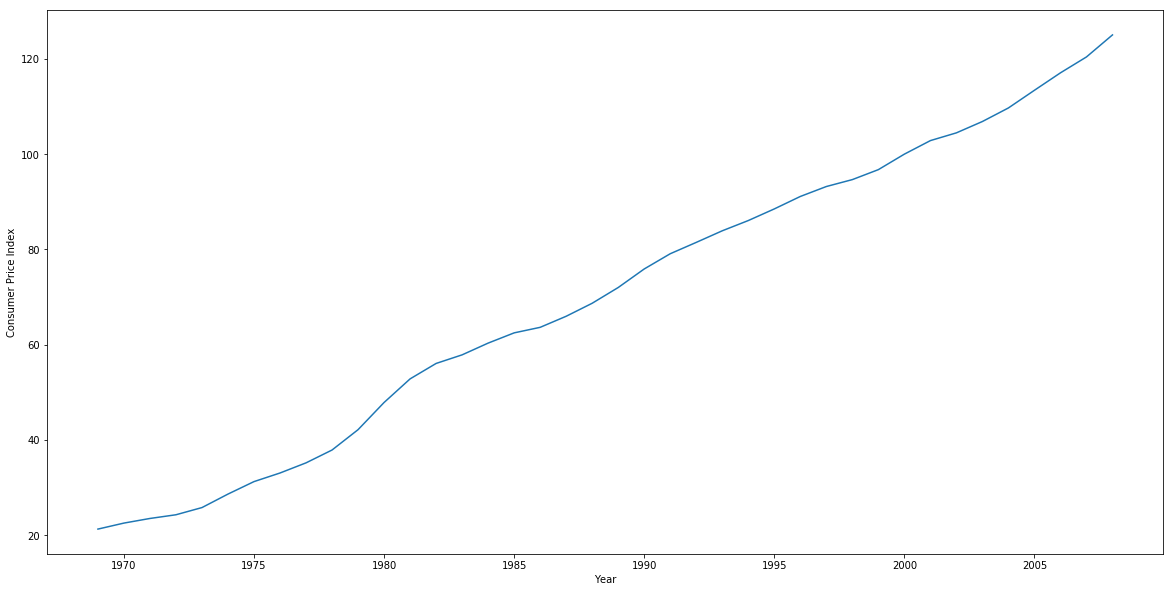

In [12]:
# Plot time series data.
import matplotlib.dates as mdates
plt.figure(figsize=(20, 10))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')
plt.plot(us_consumer_prices.index.to_pydatetime(), us_consumer_prices["Value"])


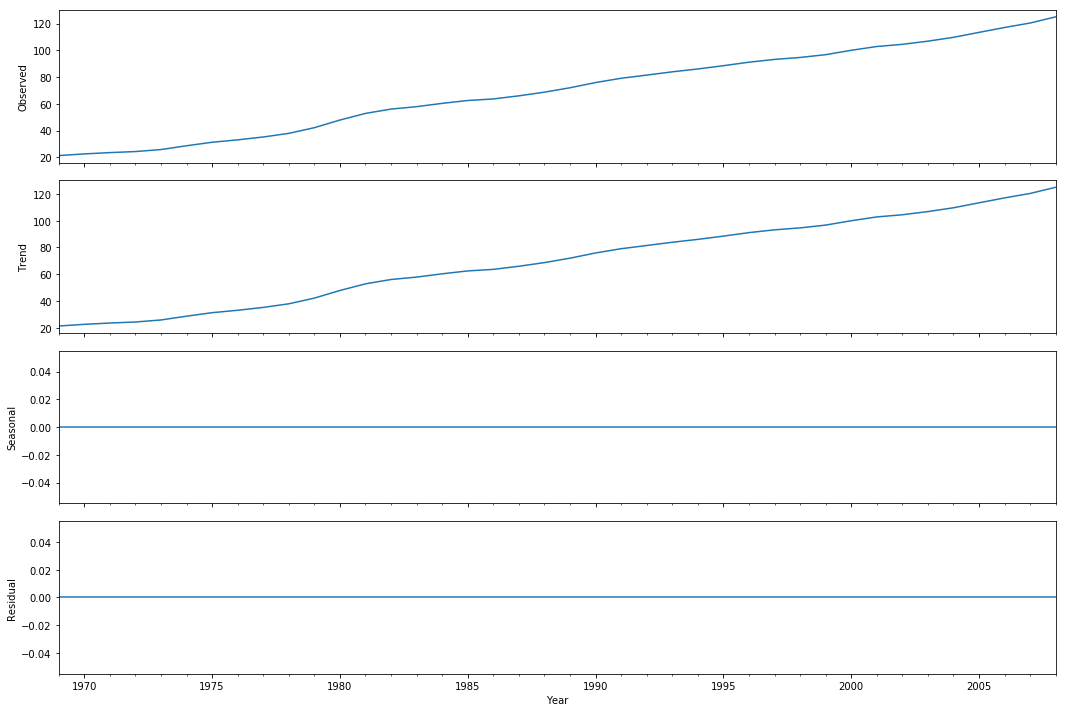

In [13]:
# Decomposition of the time series data.
import numpy
import statsmodels.api as sm
from pylab import rcParams

rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(us_consumer_prices["Value"], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

In [14]:
# Augmented Dicky-Fuller test.
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(us_consumer_prices['Value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  0.640969
p-value                         0.988583
Number of Lags Used             2.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


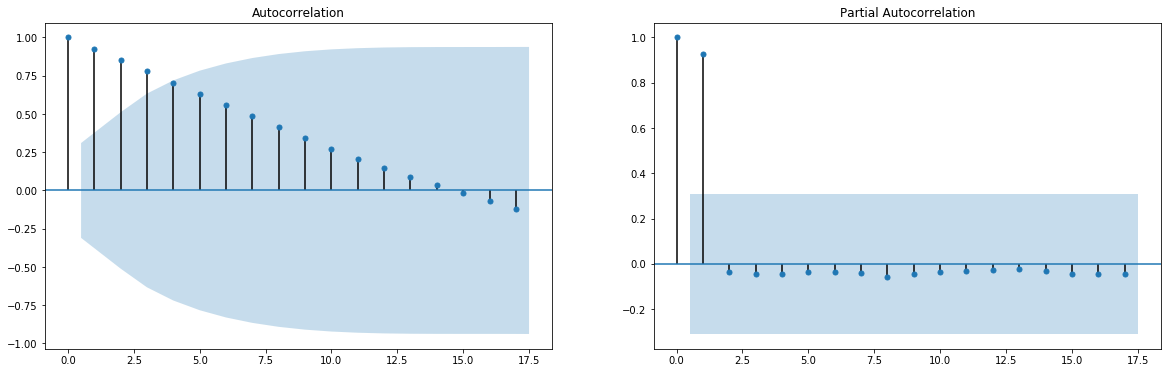

In [15]:
# Visualize the ACF and PACF plots.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
plot_acf(us_consumer_prices['Value'], ax = ax1)
plot_pacf(us_consumer_prices['Value'], ax = ax2, method='ywmle')
plt.show()

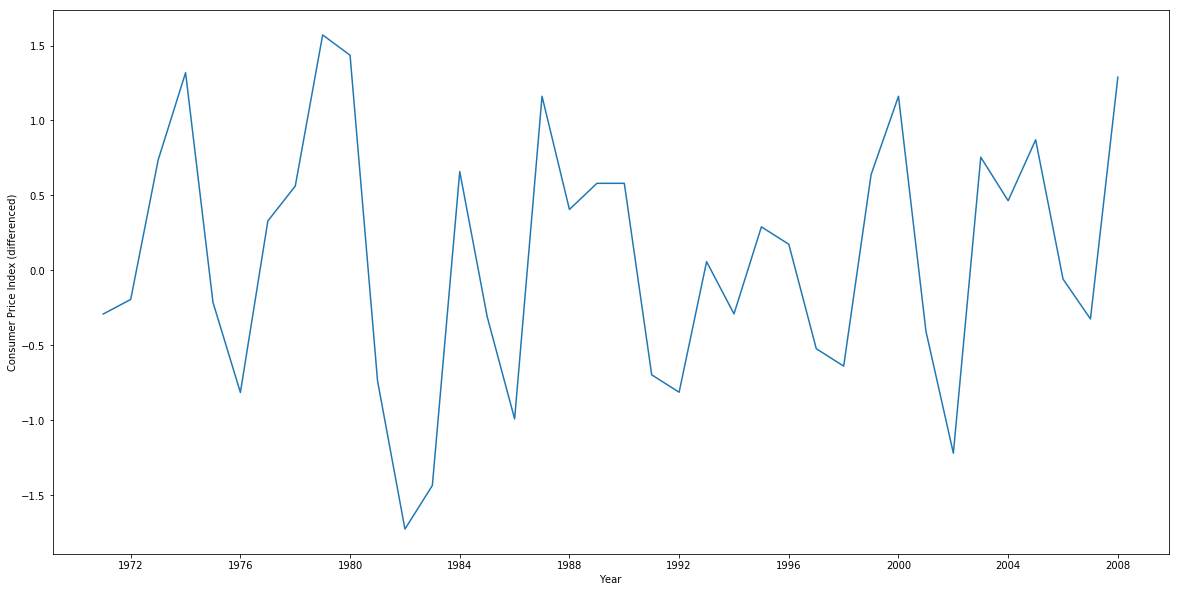

In [16]:
# Differencing - remove non-stationarity.
plt.figure(figsize=(20, 10))
us_consumer_prices_dif = (((us_consumer_prices.diff()).dropna()).diff()).dropna()

plt.xlabel('Year')
plt.ylabel('Consumer Price Index (differenced)')
plt.plot(us_consumer_prices_dif['Value'])

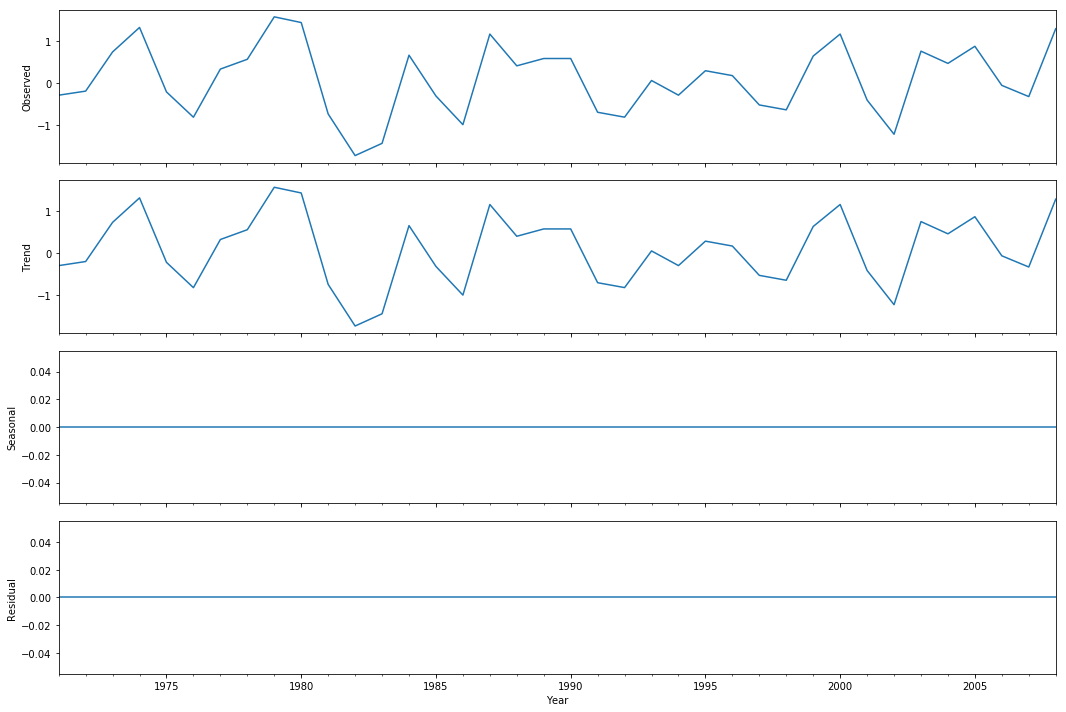

In [17]:
# Decomposition of stationarized time series.
rcParams['figure.figsize'] =15, 10
decomposition = sm.tsa.seasonal_decompose(us_consumer_prices_dif['Value'], model = 'additive')
fig = decomposition.plot()
plt.xlabel('Year')
plt.show()

In [18]:
# Augmented Dicky-Fuller test.
dftest = adfuller(us_consumer_prices_dif['Value'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -5.709087e+00
p-value                        7.370725e-07
Number of Lags Used            1.000000e+00
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64


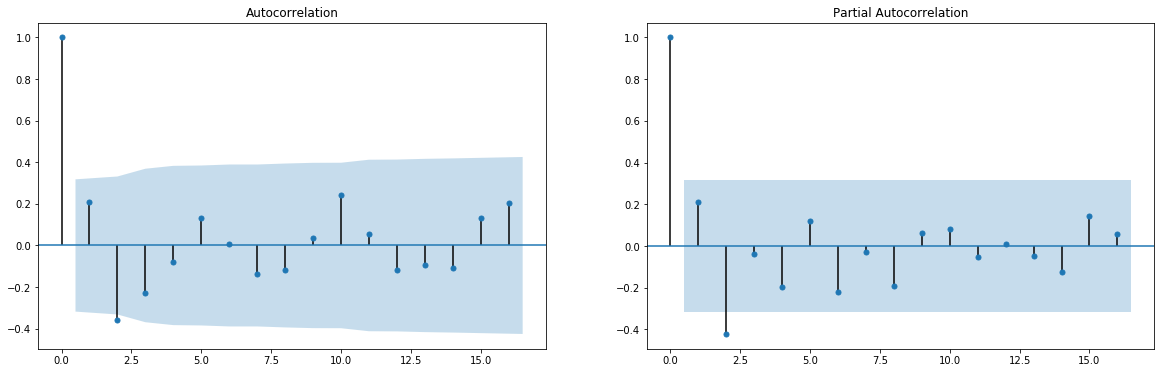

In [19]:
# Visualize the ACF and PACF plots of the stationarized series.
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
plot_acf(us_consumer_prices_dif['Value'], ax = ax1)
plot_pacf(us_consumer_prices_dif['Value'], ax = ax2, method='ywmle')
plt.show()

In [20]:
# Install the pmdarima package.
# !pip install --upgrade pmdarima

In [21]:
# Import auto-arima - grid search for ARIMA.
from pmdarima.arima import auto_arima

In [22]:
# Perform grid search for the ARIMA model.
stepwise_model = auto_arima(us_consumer_prices[:'2000'], start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, d=2, D=0, 
                            trace=True, suppress_warnings=True, error_action='ignore', stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 2, 0); AIC=78.442, BIC=81.245, Fit time=0.009 seconds
Fit ARIMA: order=(1, 2, 0); AIC=77.673, BIC=81.876, Fit time=0.022 seconds
Fit ARIMA: order=(0, 2, 1); AIC=71.611, BIC=75.815, Fit time=0.013 seconds
Fit ARIMA: order=(1, 2, 1); AIC=72.600, BIC=78.205, Fit time=0.030 seconds
Fit ARIMA: order=(0, 2, 2); AIC=72.036, BIC=77.640, Fit time=0.035 seconds
Fit ARIMA: order=(1, 2, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 0.119 seconds
71.61111416902327


In [23]:
# Fit the ARIMA model.
from statsmodels.tsa.arima_model import ARIMA
X = us_consumer_prices[:'2000']
X.index = pd.DatetimeIndex(X.index.values, freq=X.index.inferred_freq)
mod = ARIMA(X, order=(0, 2, 1))
mod_fit = mod.fit()

In [24]:
# Summary of the model.
mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Value   No. Observations:                   30
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 -32.806
Method:                       css-mle   S.D. of innovations              0.712
Date:                Wed, 23 Oct 2019   AIC                             71.611
Time:                        15:51:34   BIC                             75.815
Sample:                    01-01-1971   HQIC                            72.956
                         - 01-01-2000                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0717      0.224      0.319      0.752      -0.368       0.511
ma.L1.D2.Value     0.7494      0.145      5.158      0.000       0.465       1.034
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.3345           +0.0000j            1.3345            0.5000
-----------------------------------------------------------------------------
"""

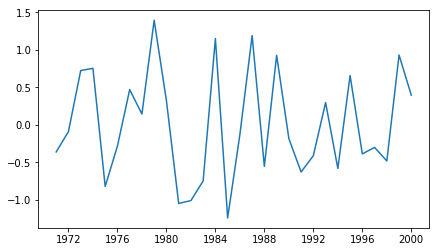

In [25]:
# Plot the residuals.
plt.figure(figsize=(7, 4))
plt.plot(mod_fit.resid)

Text(0, 0.5, 'Consumer Price Index')

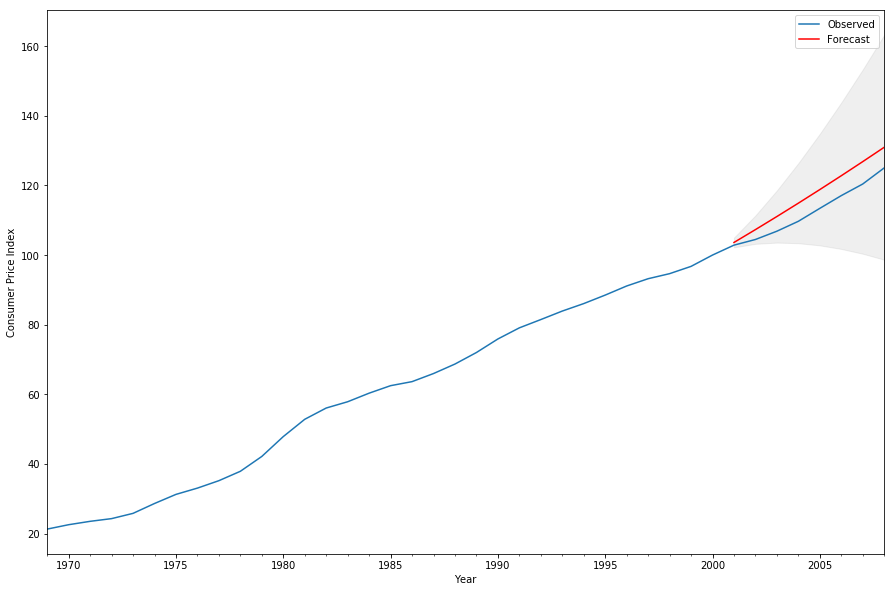

In [26]:
# Predict on the test data.
ax = us_consumer_prices['1969':'2008'].plot(label='Observed')
forecast, stderr, conf_int = mod_fit.forecast(8, alpha = .05)
forecast = pd.DataFrame(forecast).set_index(us_consumer_prices['2001':].index)
forecast.plot(ax=ax, style = 'r', label='Forecast')

# Calculate and visualize the 95% confidence interval.
ax.fill_between(us_consumer_prices['2001':].index, conf_int[:,0], conf_int[:,1], color='dimgray', alpha=0.1)

# Add the labels to the plot.
plt.legend(('Observed', 'Forecast'))
plt.xlabel('Year')
plt.ylabel('Consumer Price Index')